In [1]:
'''
This script is a study of the fall time of the data set. 
The goal is to determine how the fall time of the exponential decay is determined.
It will examine the behavior on a per pixel basis initially and then energy dependence
will be examined as well.
'''
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import optimize
import os
import pickle

from multiprocessing import Lock, Process, Queue, current_process 
import multiprocessing as mp

from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors

In [3]:
#first define a bunch of commonly used functions
#this adjusts the waveform to have a 0 baseline and whatnot
def baselineShift(wave, window):
    #flip the waveform over
    wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave    
     
#fit to an exponential
def singleExp(x, amp, decay1, const):
    x = np.arange(len(x))
    y = amp * np.exp(-x/decay1) + const
    return y

#fit a difference of exponentials
def doubleExp(x, amp, decay1, decay2, t0, const):
    y = np.arange(len(x))
    y = amp * (np.exp(-y/decay1) - np.exp(-y/decay2))
    y = np.roll(y, t0)
    y[0:t0]=0.
    return y + const

#the initial guesses for the fit parameters for the single exponential
def singleGuesses(wave):
    amp = np.mean(wave[0:10])
    if amp < 0:
        amp = 0
    const = np.mean(wave[:-10])
    decay = 120
    return [amp, decay, const]


#this does the fitting for the falling edge of each peak
def fitSingleFunc(waveform, peaks, after = 10, length = 100, pretrig = 10000):
    results = []
    err = np.mean(np.square(waveform[0:pretrig]))
    for peak in peaks:
        #first go to the location of the peak and snag a piece of the waveform
        wave = waveform[peak+after:peak+after+length]
        #this piece should only be the decaying part, hopefully
        guesses = singleGuesses(wave)
        #do the fitting
        xdata = np.arange(len(wave))
        popt,pcov = optimize.curve_fit(singleExp, xdata, wave, p0=guesses, bounds=([0,0,-2000],[10000,4000,10000]),maxfev=5000)
        chisqr = np.sum((singleExp(wave, *popt) - wave)**2.0) / ((len(wave) - len(popt))*err**2.0)
        results.append([*popt, chisqr])
    return results        

#this function defines and applies the trapezoidal filter to the waveform
def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt*=scale
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def findPeaks(wave):
    height = None
    threshold = None
    distance = 500
    prominence = 50
    width = 100
    wlen = None
    rel_height = 0.5
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    dataFileNames.sort()
    return dataFileNames


def perWaveAnalysis(wave):
    cleanwave = baselineShift(wave, 10000)
    trappedWave = trapezoidalFilter(cleanwave, 500, 1, 150)
    peaks = findPeaks(trappedWave)
    res = fitSingleFunc(cleanwave, peaks, after=0, length=1000, pretrig=10000)
    return res

In [4]:
files = getFileNames('/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/')

In [5]:
decayTimeResults = []
pixelList = [i for i in range(16)]
for pixel in pixelList:
    decayTimeResults.append([])

if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    for file in files:
        data = df.dataFile(file)
        print(file)
        for p in range(len(pixelList)):
            #print('\t',pixelList[p])
            waves = data.getPixel(pixelList[p])
            results = pool.map(perWaveAnalysis, [wave for wave in waves])
            decayTimeResults[p].extend(results)

/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44486.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44487.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44488.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44489.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44490.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44491.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44492.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44493.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44494.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44495.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44496.bin
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44486-44785/run44

In [6]:
decayTimeResultsFile = open('decayTimeResults.pkl', 'wb')
pickle.dump(decayTimeResults, decayTimeResultsFile)

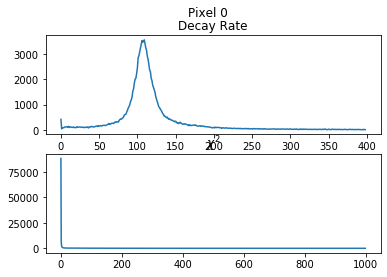

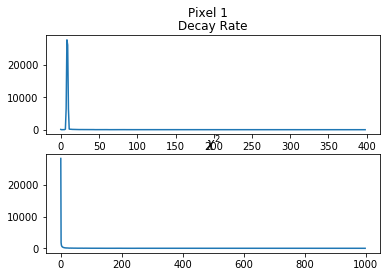

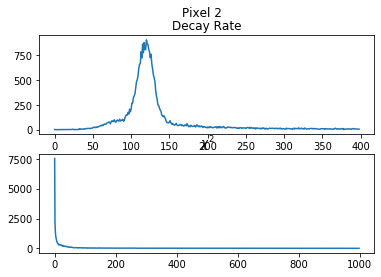

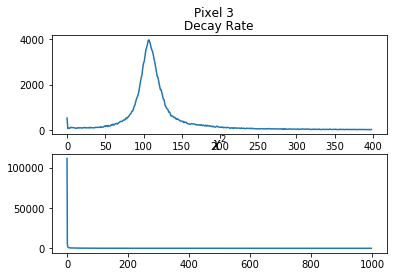

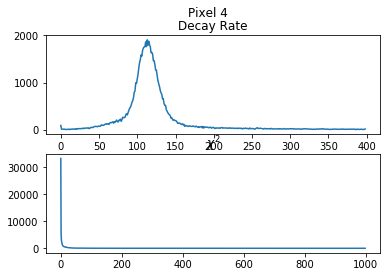

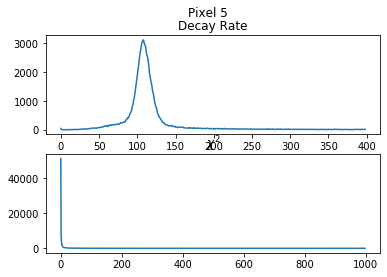

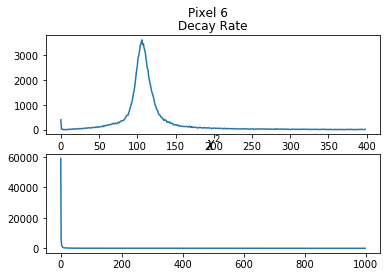

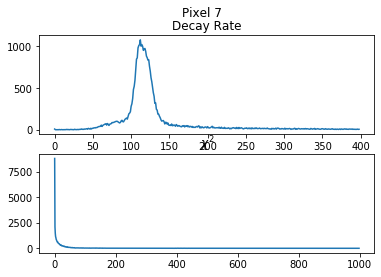

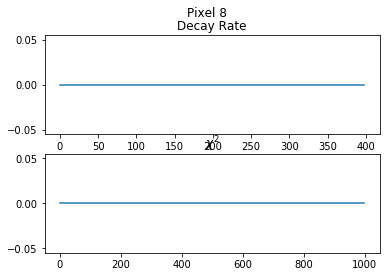

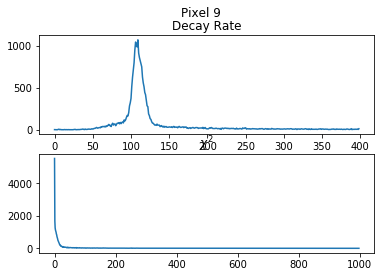

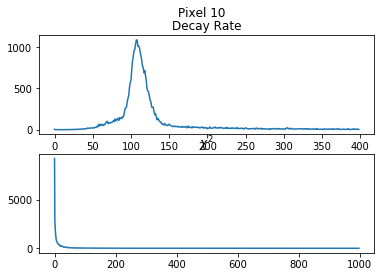

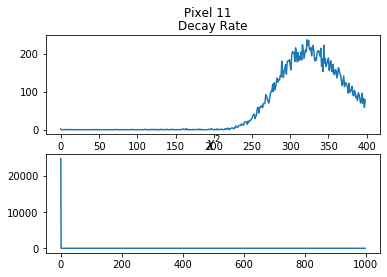

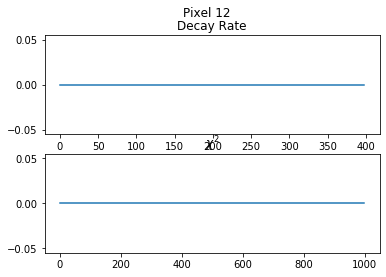

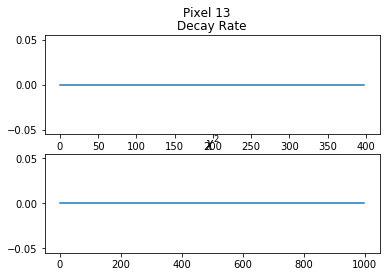

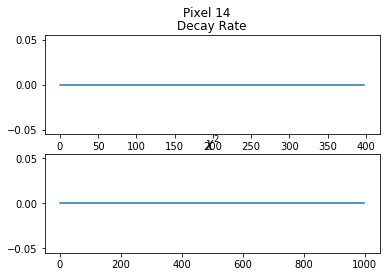

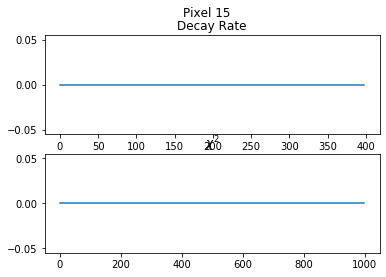

In [36]:
decayHists = []
chiHists = []
for p in range(len(pixelList)):
    #grab all of the results for each pixel
    pixelRes = decayTimeResults[p]
    decays = []
    chis = []
    for wave in pixelRes: #now iterate over the waveforms
        for peak in wave: #iterate over the peaks in that waveform
            decays.append(peak[1])
            chis.append(peak[3])
    decayHist = np.histogram(decays, bins = np.arange(0,400,1))
    chiHist = np.histogram(chis, bins = np.arange(0,1000,1))
    decayHists.append(decayHist)
    chiHists.append(chiHist)
    f, (ax1, ax2) = plt.subplots(2,1)
    ax1.set_title('Decay Rate')
    ax1.plot(decayHist[1][:-1], decayHist[0])
    ax2.set_title(r'$\chi^2$')
    ax2.plot(chiHist[1][:-1], chiHist[0])
    f.suptitle('Pixel '+str(pixelList[p]))
    plt.savefig('Decay Rate for Pixel '+ str(pixelList[p])+'.png')
    plt.show()

In [38]:
#now use these histograms to fit the peak
def gaussian(x, amp, mu, sig):
    return amp * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) 

def gaussianGuesses(hist):
    mean = hist[1][np.argmax(hist[0])]
    amp = np.max(hist[0])
    zero_crossings = np.where(np.diff(np.sign(hist[0]-amp*1/2)))[0]
    if len(zero_crossings) < 2:
        width = 0
    else:
        width = zero_crossings[1] - zero_crossings[0]
    return mean, amp, width

fitParams = []
for hist in decayHists:
    initGuesses = gaussianGuesses(hist)
    popt, pcov = optimize.curve_fit(gaussian, hist[1][:-1], hist[0], p0=initGuesses)
    fitParams.append(popt)

/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
for fit in fitParams:
    print(fit)

[ 109. 3559.   24.]
[8.000e+00 2.757e+04 2.000e+00]
[120. 908.  25.]
[ 107. 3979.   25.]
[ 113. 1905.   31.]
[ 108. 3124.   20.]
[ 106. 3615.   21.]
[ 112. 1077.   23.]
[0. 0. 0.]
[ 109. 1071.   15.]
[ 107. 1086.   22.]
[209.77802432 327.38714061  42.53629061]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
